## Modelling Corn Plant Disease Classification with EfficientNet
# Summary & How to Use

The use of this web utlity platform is to let users of the internet upload pictures of corn plant images, have it be classified and get a determination output as to what kind of disease it shows. The platform will be UI/UX friendly for everyone of age, showing relevancy of informations about the indicated diseases. It is an integrated system of web development and AI modelling.

### Setting up Parameters and Libraries

In [1]:
%%bash

python3 -m venv --system-site-packages ./venv

In [2]:
%%bash

source ./venv/bin/activate
pip install --upgrade pip
#pip list

In [3]:
 
%pip install --upgrade -q Pillow
%pip install -q tensorflow
%pip install -q keras
%pip install -q split-folders
%pip install -q opendatasets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import splitfolders
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import opendatasets as od
import shutil
import functools

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, classification_report
from time import process_time

2022-05-20 16:16:33.341244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 16:16:33.341287: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Download Kaggle Datasets Using Opendatasets

In [5]:
od.download('https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset')

Skipping, found downloaded files in "./new-plant-diseases-dataset" (use force=True to force download)


In [6]:
base_path = r"./new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
corn1 = base_path + r"/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot"
corn2 = base_path + r"/Corn_(maize)___Common_rust_"
corn3 = base_path + r"/Corn_(maize)___healthy"
corn4 = base_path + r"/Corn_(maize)___Northern_Leaf_Blight"

!mkdir -p corn_data
destination_path = "./corn_data"
corndest1 = destination_path + "/raw/Cercospora_leaf_spot Gray_leaf_spot"
corndest2 = destination_path + "/raw/Common_rust"
corndest3 = destination_path + "/raw/Healthy"
corndest4 = destination_path + "/raw/Northern_leaf_blight"


shutil.copytree(corn1, corndest1, dirs_exist_ok=True)
shutil.copytree(corn2, corndest2, dirs_exist_ok=True)
shutil.copytree(corn3, corndest3, dirs_exist_ok=True)
shutil.copytree(corn4, corndest4, dirs_exist_ok=True)


'./corn_data/raw/Northern_leaf_blight'

In [7]:
# the ratio to split the data which goes into 90% training, 5% validation, 5% test
splitfolders.ratio(destination_path + "/raw", destination_path, seed=7777, ratio=(0.9, 0.05, 0.05), group_prefix=None)

train_dir = destination_path + "/train"
valid_dir = destination_path + "/val"
test_dir = destination_path + "/test"

diseases = os.listdir(train_dir)

print(diseases)
print("\nTotal disease classes are: {}".format(len(diseases)))

Copying files: 7316 files [00:03, 2187.98 files/s]

['Common_rust', 'Healthy', 'Cercospora_leaf_spot Gray_leaf_spot', 'Northern_leaf_blight']

Total disease classes are: 4


### Exploring the Data

In [8]:
# Exploring the data gathered
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])
print(img_per_class)

n_train = 0
for val in nums.values():
    n_train += val
print(f"\nThere are {n_train} images in total ready for training.")

                                     No. of images
Common_rust                                   1716
Healthy                                       1673
Cercospora_leaf_spot Gray_leaf_spot           1477
Northern_leaf_blight                          1717

There are 6583 images in total ready for training.


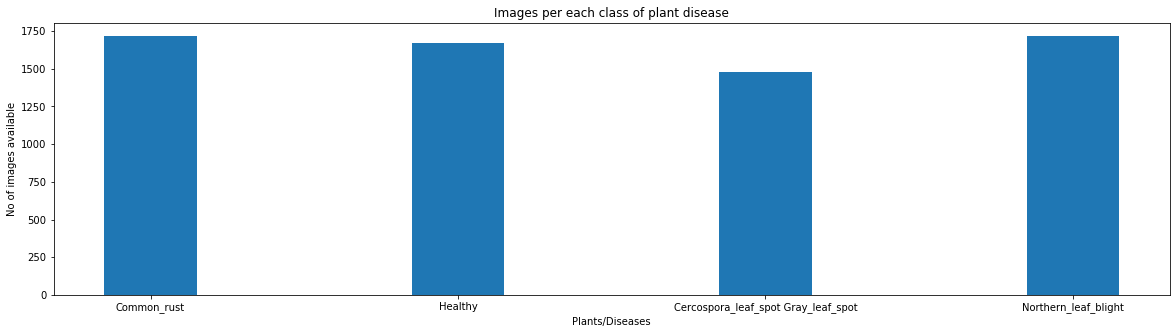

In [9]:
index = [n for n in range(4)]
plt.figure(figsize=(20,5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases')
plt.ylabel('No of images available')
plt.xticks(index, diseases)
plt.title('Images per each class of plant disease')
plt.savefig('assets/Distribution of Data.png')

### Preparing the Data for Training

In any machine learning project, it is critical to set up a trustworthy validation scheme, in order to properly evaluate and compare models. This is especially true if the dataset is small which is the case of this project. For a typical image classification problem, the standard approach is to take a deep CNN model (such as the most popular EffcientNet) trained on ImageNet, replace the last layer so that the output dimension equals the target's dimension, and fine tune it on the specific dataset.

In [82]:
image_res = (224, 224)
batch_size = 32
test_gen = ImageDataGenerator()
train_set = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=image_res, label_mode='categorical', batch_size=batch_size)
val_set = tf.keras.utils.image_dataset_from_directory(valid_dir, image_size=image_res, label_mode="categorical", batch_size=batch_size, shuffle=False)
test_set = test_gen.flow_from_directory(test_dir, target_size=image_res, batch_size=batch_size, shuffle=False)
test_image_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=image_res, label_mode='categorical', batch_size=batch_size, shuffle=True)

class_names = train_set.class_names
print(class_names)

train_set = train_set.map(lambda image, label: (tf.image.resize(image, image_res), label))
val_set = val_set.map(lambda image, label: (tf.image.resize(image, image_res), label))


Found 6583 files belonging to 4 classes.
Found 364 files belonging to 4 classes.
Found 369 images belonging to 4 classes.
Found 369 files belonging to 4 classes.
['Cercospora_leaf_spot Gray_leaf_spot', 'Common_rust', 'Healthy', 'Northern_leaf_blight']


In [11]:
# Setting up AUTOTUNE for the next batch of images to automatically be loaded in via cache
train_set = train_set.prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest"),
    tf.keras.layers.RandomFlip("horizontal"),
], name="data_augmentation")

(32, 224, 224, 3)
(32, 4)


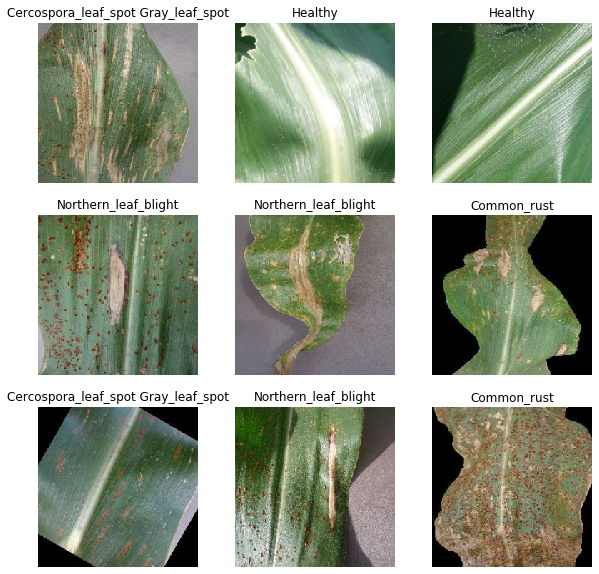

In [13]:
# Visualizations before data augmentation
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_set.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # print(np.array(labels[i]))
    label = np.array(labels[i])
    label_index = np.where(label == 1)
    res = functools.reduce(lambda sub, ele: sub * 10 + ele, label_index)
    plt.title(class_names[res[0]])
    plt.axis("off")
    plt.savefig('assets/Original Images Preview.png')

for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

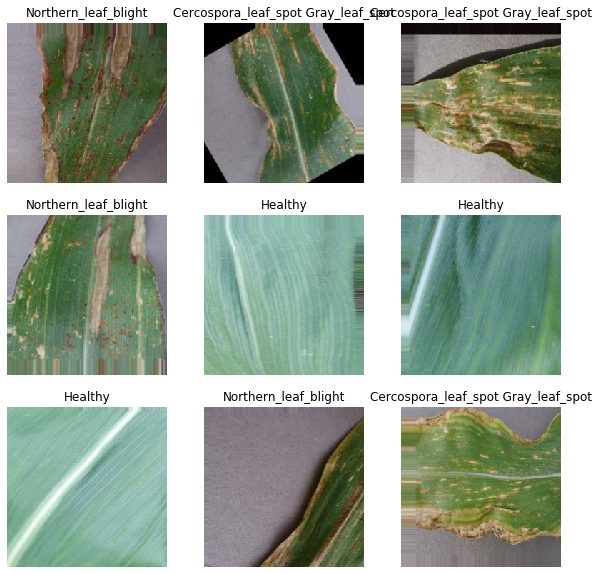

In [14]:
# Visualization after data augmentation
plt.figure(figsize=(10, 10))
for image, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = data_augmentation(image)
        plt.imshow(aug_img[i].numpy().astype("uint8"))
        label = np.array(labels[i])
        label_index = np.where(label == 1)
        res = functools.reduce(lambda sub, ele: sub * 10 + ele, label_index)
        plt.title(class_names[res[0]])
        plt.axis('off')
        plt.savefig('assets/Augmented Images Preview.png')

### Features Extraction

In [15]:
!mkdir -p saved-model
checkpoint = ModelCheckpoint('saved-model/best_model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.001)

In [16]:
tf.random.set_seed(7777)
base_model = EfficientNetB0(weights='imagenet', include_top=False)
base_model.trainable = False

input_shape = (224,224,3)
output_size = 4

inputs = tf.keras.layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = Dense(output_size, activation='softmax', dtype=tf.float32)(x)
final_effinet_model = tf.keras.Model(inputs, outputs)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
final_effinet_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=["accuracy"])
final_effinet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124  

In [17]:
# Printing out features for training and validation
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
feature_batch_mod = final_effinet_model(image_batch)

validation_batch, val_label_batch = next(iter(val_set))
valid_batch = base_model(validation_batch)
valid_batch_mod = final_effinet_model(validation_batch)

print(feature_batch.shape)
print(valid_batch.shape)

print(feature_batch_mod.shape)
print(valid_batch_mod.shape)


(32, 7, 7, 1280)
(32, 7, 7, 1280)
(32, 4)
(32, 4)


### Apply Transfer Learning

In [18]:
tf.random.set_seed(7777)
time_start = process_time()
epochs = 20
hist = final_effinet_model.fit(train_set, epochs=epochs, validation_data=val_set, callbacks=[checkpoint, earlystop], steps_per_epoch=len(train_set), validation_steps=len(val_set))
time_end = process_time()

print('Elapsed Processing Time: ', round((time_end-time_start)/360, 2), 'mins')

Epoch 1/20
206/206 [==============================] - ETA: 0s - loss: 0.8824 - accuracy: 0.7290
Epoch 1: val_loss improved from inf to 0.58981, saving model to saved-model/best_model
206/206 [==============================] - 443s 2s/step - loss: 0.8824 - accuracy: 0.7290 - val_loss: 0.5898 - val_accuracy: 0.8654
Epoch 2/20
206/206 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.9038
Epoch 2: val_loss improved from 0.58981 to 0.36479, saving model to saved-model/best_model
206/206 [==============================] - 448s 2s/step - loss: 0.4693 - accuracy: 0.9038 - val_loss: 0.3648 - val_accuracy: 0.9341
Epoch 3/20
206/206 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.9260
Epoch 3: val_loss improved from 0.36479 to 0.27153, saving model to saved-model/best_model
206/206 [==============================] - 448s 2s/step - loss: 0.3324 - accuracy: 0.9260 - val_loss: 0.2715 - val_accuracy: 0.9478
Epoch 4/20
206/206 [===========================

### Saving Model

In [19]:
# Saving it as Tensorflow SavedModel
final_effinet_model.save('saved-model/best_model')

# Saving it as an HDF5 File Format
final_effinet_model.save('saved-tl-model.h5', save_format='h5')

2022-05-20 18:44:27.851797: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model/best_model/assets


### Visualization of Model Training

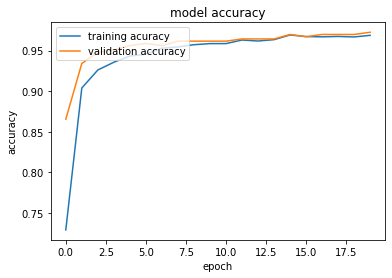

In [20]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["training acuracy", "validation accuracy"], loc="upper left")
    plt.savefig('assets/B0 Model Accuracy Plot History.png')
    plt.show()

plot_hist(hist)

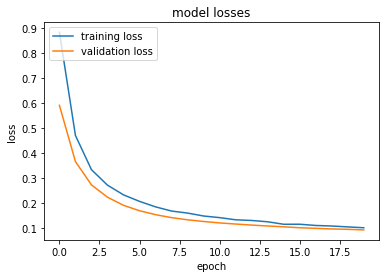

In [21]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model losses")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["training loss", "validation loss"], loc="upper left")
    plt.savefig('assets/B0 Model Loss Plot History.png')
    plt.show()

plot_hist(hist)

### Model Prediction Against Test Dataset

In [22]:
final_effinet_model.evaluate(test_set)

12/12 [==============================] - 23s 2s/step - loss: 0.0815 - accuracy: 0.9810


[0.08153942972421646, 0.9810298085212708]

In [23]:
predict_model = final_effinet_model.predict(test_set, verbose=2)
print("Prediction Result Shape: ", predict_model.shape)
predict_model

12/12 - 20s - 20s/epoch - 2s/step
Prediction Result Shape:  (369, 4)


array([[9.8913866e-01, 1.5041372e-05, 2.5260404e-05, 1.0821014e-02],
       [9.6663117e-01, 3.5275277e-04, 3.6123139e-04, 3.2654811e-02],
       [3.2263443e-01, 4.8454002e-02, 3.2349310e-03, 6.2567675e-01],
       ...,
       [6.1612162e-03, 1.6166428e-04, 4.4371163e-06, 9.9367273e-01],
       [3.4146623e-03, 5.5857699e-02, 1.4325087e-03, 9.3929511e-01],
       [2.0100236e-02, 1.2864628e-03, 2.7871208e-06, 9.7861052e-01]],
      dtype=float32)

In [24]:
y_pred = np.argmax(predict_model, axis=1)
print(y_pred, y_pred.shape)

[0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 1 0 3 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 3 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3] (369,)


### Accuracy Score

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(test_set.classes, y_pred.round())

0.981029810298103

### Confusion Matrix

[[77  2  0  4]
 [ 0 96  0  0]
 [ 0  0 94  0]
 [ 0  1  0 95]]
[[0.92771084 0.02409639 0.         0.04819277]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.01041667 0.         0.98958333]]


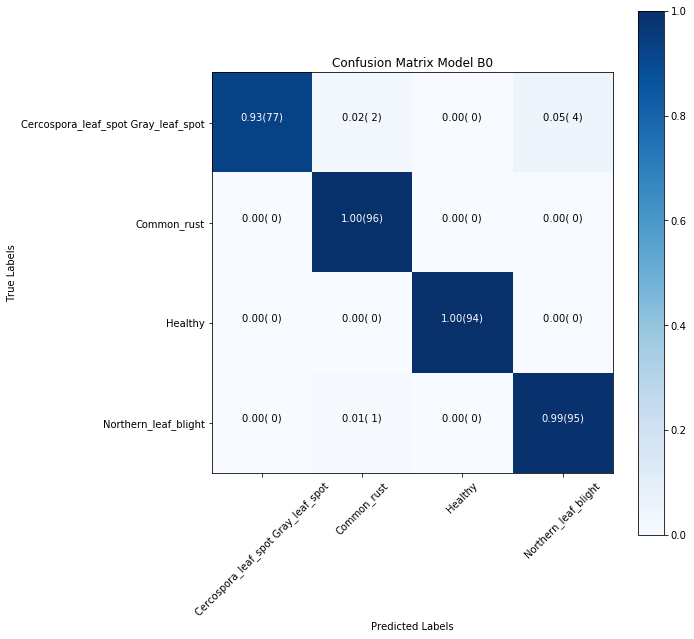

In [26]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_set.classes, y_pred) 
print(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(10, 10))
plt.imshow(cm_normalized, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.title("Confusion Matrix Model B0")

# Inserting strings inside each boxes
thresh = 0.8 * cm_normalized.max() / 1
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
    str_normal = '{:.2f}'.format(cm_normalized[i, j])
    str_non = '({:2d})'.format(cm[i, j])
    plt.text(j, i, str_normal + str_non, horizontalalignment='center', verticalalignment='bottom', color='white' if cm_normalized[i, j] > thresh else 'black')

plt.tight_layout()
plt.colorbar()
plt.savefig('assets/Confusion Matrix Model B0.png')
plt.show()

### F1 Score

In [27]:
report = classification_report(test_set.classes, y_pred, output_dict=True)
report

{'0': {'precision': 1.0,
  'recall': 0.927710843373494,
  'f1-score': 0.9625,
  'support': 83},
 '1': {'precision': 0.9696969696969697,
  'recall': 1.0,
  'f1-score': 0.9846153846153847,
  'support': 96},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 94},
 '3': {'precision': 0.9595959595959596,
  'recall': 0.9895833333333334,
  'f1-score': 0.9743589743589745,
  'support': 96},
 'accuracy': 0.981029810298103,
 'macro avg': {'precision': 0.9823232323232323,
  'recall': 0.9793235441767069,
  'f1-score': 0.9803685897435898,
  'support': 369},
 'weighted avg': {'precision': 0.9816046645314939,
  'recall': 0.981029810298103,
  'f1-score': 0.9808917031478007,
  'support': 369}}

In [28]:
f1_score = {}

for key,value in report.items():
    if key == "accuracy":
        break
    else:
        f1_score[class_names[int(key)]] = value['f1-score']

f1_score

{'Cercospora_leaf_spot Gray_leaf_spot': 0.9625,
 'Common_rust': 0.9846153846153847,
 'Healthy': 1.0,
 'Northern_leaf_blight': 0.9743589743589745}

In [29]:
f1_report = pd.DataFrame({"class_names": list(f1_score.keys()), "f1_score": list(f1_score.values())})
f1_report.to_json('assets/f1_score.json')
f1_report

,class_names,f1_score
0,Cercospora_leaf_spot Gray_leaf_spot,0.962500
1,Common_rust,0.984615
2,Healthy,1.000000
3,Northern_leaf_blight,0.974359


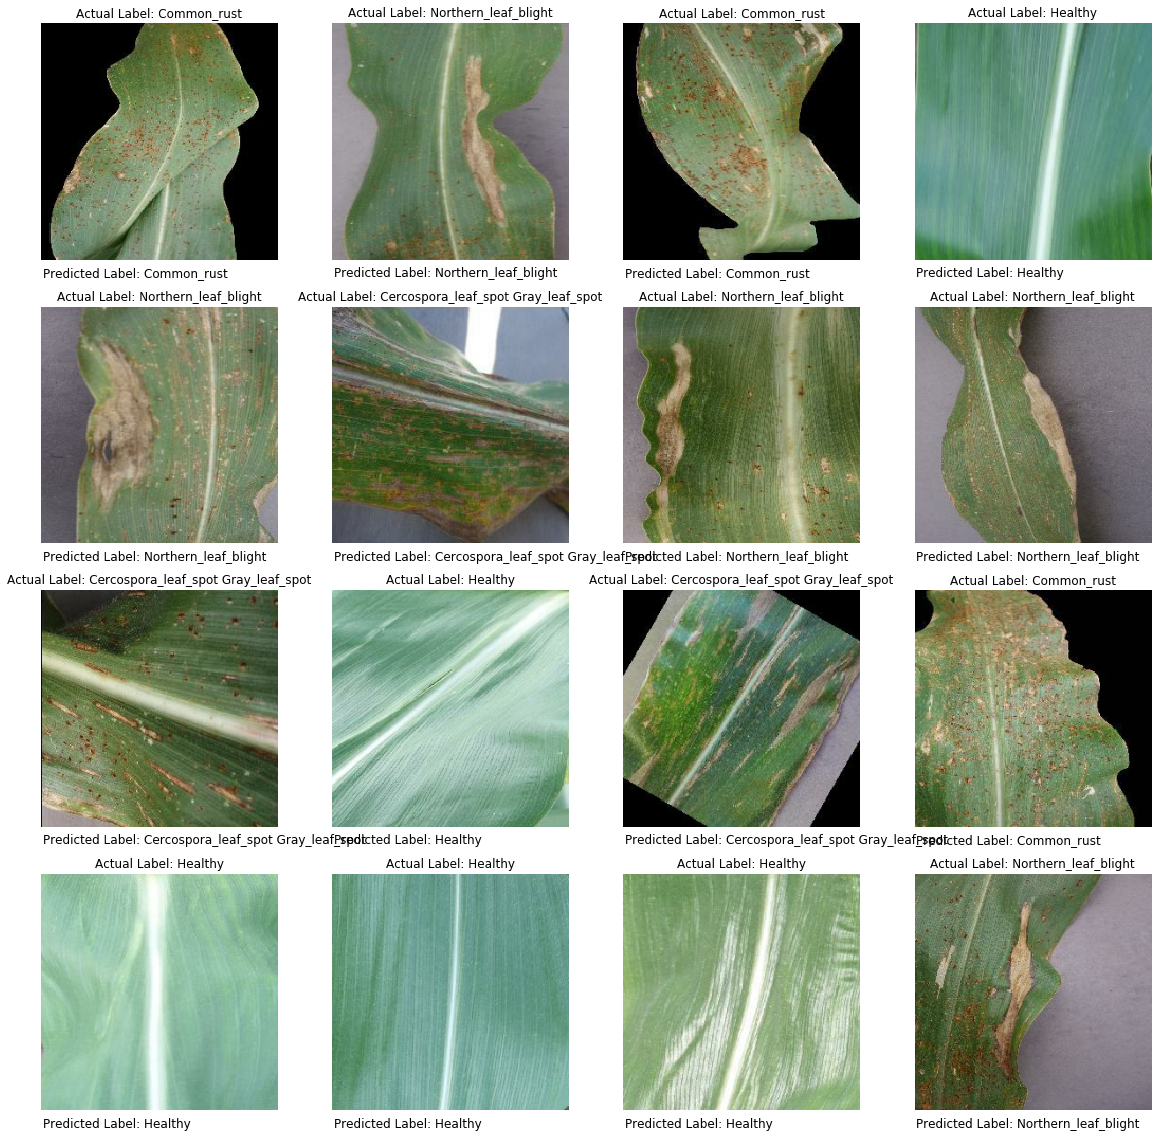

In [83]:
plt.figure(figsize=(20, 20))
for images, labels in test_image_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        
        img = tf.keras.preprocessing.image.img_to_array(images[i])
        img = np.expand_dims(img, axis=0)

        pred = final_effinet_model.predict(img)
        # print(np.argmax(pred))
        plt.imshow(images[i].numpy().astype("uint8"))
        label = np.array(labels[i])
        label_index = np.where(label == 1)
        res = functools.reduce(lambda sub, ele: sub * 10 + ele, label_index)
        plt.title("Actual Label: %s" % class_names[res[0]])
        plt.text(1, 240, "Predicted Label: %s" % class_names[np.argmax(pred)], fontsize=12)
        plt.axis("off")